In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys 
import os

In [3]:
parent_dir = os.path.join(os.getcwd(), os.pardir)
sys.path.append(parent_dir)

In [4]:
from src import model
from src import utils

In [5]:
import numpy as np
import pandas as pd
import scipy
import datetime

In [6]:
import pymc3 as pm

In [7]:
import theano.tensor as tt

In [8]:
import matplotlib.pyplot as plt

In [9]:
n_series = 10
n_years = 4

In [20]:
df = utils.random_timeseries(n_series=n_series, n_years=n_years)

scalers = {}

for col in [col for col in df.columns if col[0] in ['t', 'y']]:
    
    scaler = utils.MinMaxScaler(centering=False)
    df[col] = scaler.fit_transform(df[col])
    
    scalers[col] = scaler

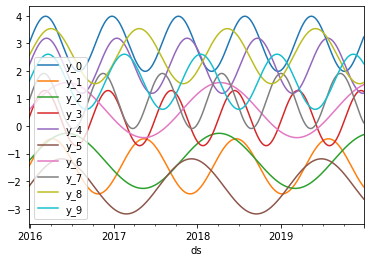

In [21]:
df.set_index(df['ds']).drop(columns=['t', 'ds']).plot()

In [36]:
def det_dot(a, b):
    """
    The theano dot product and NUTS sampler don't work with large matrices?
    
    :param a: (np matrix)
    :param b: (theano vector)
    """
    return (a * b[None, :]).sum(axis=-1)

In [37]:
def fourier_series(t, p=365.25, n=10):
    # 2 pi n / p
    x = 2 * np.pi * np.arange(1, n + 1) / p
    # 2 pi n / p * t
    x = x * t[:, None]
    x = np.concatenate((np.cos(x), np.sin(x)), axis=1)
    return x

In [38]:
df_stack = df.set_index([df['t'], df['ds']], drop=True).drop(columns=['t', 'ds']).stack()

y = df_stack.values
t = np.array([x[0] for x in df_stack.index.values])
ds = np.array([x[1] for x in df_stack.index.values])
idx = np.array([int(x[2][2]) for x in df_stack.index.values])

In [39]:
n_changepoints = 10
n_fourier_yearly = 10
n_fourier_weekly = 4

s = np.linspace(0, 0.8 * np.max(t), n_changepoints + 1)[1:]

# * 1 casts the boolean to integers
# A is a boolean matrix specifying which observation time stamps (vector t) --> rows
# have surpasses which changepoint time stamps (vector s) --> columns
A = (t[:, None] > s) * 1

F_yearly = fourier_series(t, scalers['t'].transform(365.25), n_fourier_yearly) # Seasonality w/ yearly period
F_weekly = fourier_series(t, scalers['t'].transform(7), n_fourier_weekly) # Seasonality w/ weekly period

In [40]:
print("F_yearly: ", F_yearly.shape)
print("F_weekly: ", F_weekly.shape)
print("A: ", A.shape)
print("t: ", t.shape)

F_yearly:  (14610, 20)
F_weekly:  (14610, 8)
A:  (14610, 10)
t:  (14610,)


In [43]:
# Generate a PyMC3 Model context
model = pm.Model()

with model:
    
    # Hyper priors
    mu_beta_yearly = pm.Normal('mu_beta_yearly', mu=0., sd=1)
    sigma_beta_yearly = pm.HalfCauchy('sigma_beta_yearly', beta=10)
    mu_beta_weekly = pm.Normal('mu_beta_weekly', mu=0., sd=1)
    sigma_beta_weekly = pm.HalfCauchy('sigma_beta_weekly', beta=10)
    
    # Priors
    k = pm.Normal('k', 0, 5, shape=n_series)
    m = pm.Normal('m', 0, 5, shape=n_series)
    delta = pm.Laplace('delta', 0, 0.05, shape = (n_series, n_changepoints))
    beta_yearly = pm.Normal('beta_yearly', mu_beta_yearly, 
                            sigma_beta_yearly, shape = (n_fourier_yearly * 2, n_series))
    beta_weekly = pm.Normal('beta_weekly', mu_beta_weekly, 
                            sigma_beta_yearly, shape = (n_fourier_weekly * 2, n_series))
    
    # tt.printing.Print('1')(A * delta[idx, :])
    # tt.printing.Print('2')((k[idx] + (A * delta[idx, :]).sum(axis=1)))
    # tt.printing.Print('3')(m[idx]) 
    # tt.printing.Print('4')((A * gamma).sum(axis=1))
    
    # Model
    
    # Linear trend
    gamma = -s * delta[idx, :]
    mu = (k[idx] + (A * delta[idx, :]).sum(axis=1)) * t + m[idx] + (A * gamma).sum(axis=1) 
    
    # print("F_yearly: ", F_yearly.shape)
    # beta_yearly2 = beta_yearly[:, idx].T
    # beta_yearly_print = tt.printing.Print('beta_yearly2')(beta_yearly2)
    
    # Seasonality
    # xx = (F_yearly * beta_yearly[:, idx].T).sum(axis=-1)
    # xx_print = tt.printing.Print('xx')(xx)
    
    mu += (F_yearly * beta_yearly[:, idx].T).sum(axis=-1)
    mu += (F_weekly * beta_weekly[:, idx].T).sum(axis=-1)
    
    # Likelihood
    sigma = pm.HalfCauchy('sigma', 0.5, testval=1, shape=n_series)
    Y_obs = pm.Normal('Y_obs', mu=mu, sd=sigma[idx], observed=y)  

In [44]:
with model:
    trace = pm.sample(500)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma, beta_weekly, beta_yearly, delta, m, k, sigma_beta_weekly, mu_beta_weekly, sigma_beta_yearly, mu_beta_yearly]
Sampling 2 chains, 0 divergences:  24%|██▍       | 485/2000 [00:19<00:59, 25.48draws/s]


RuntimeError: Chain 0 failed.

In [ ]:
pm.traceplot(trace)

In [ ]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025
# vector distributions
tr_beta_yearly = trace['beta_yearly']
tr_beta_weekly = trace['beta_weekly']
tr_delta = trace['delta']

# scalar distributions
tr_k = trace['k']
tr_m = trace['m']

In [ ]:
idx_series = 1

series_ds = ds[idx==idx_series]
series_beta_yearly = tr_beta_yearly[:,:,idx_series]
series_beta_weekly = tr_beta_weekly[:,:,idx_series]
series_t = t[idx==idx_series]
series_A = A[idx==idx_series, :]
series_F_yearly = F_yearly[idx==idx_series,:]
series_F_weekly = F_weekly[idx==idx_series,:]

In [ ]:
# determine the posterior by evaulating all the values in the trace.
trend_posterior = (tr_k + np.dot(series_A, tr_delta.T)) * series_t[:, None] 
trend_posterior += tr_m[:, idx_series] + np.dot(series_A, (-s * tr_delta).T)

seasonality_yearly = det_seasonality_posterior(series_beta_yearly, series_F_yearly)
seasonality_weekly = det_seasonality_posterior(series_beta_weekly, series_F_weekly)

fitted = (trend_posterior + seasonality_yearly + seasonality_weekly)#.mean(1)

In [ ]:
date = pd.Series(series_ds)
sunday = np.argmax(df['ds'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['ds'].dt.dayofyear)

plt.figure(figsize=(16, 3*6))
b = 411
plt.subplot(b)
plt.title('total')
plt.plot(date, fitted, lw=0.5)
plt.scatter(df['ds'], df['y_{}'.format(idx_series)], s=0.5, color='black')

plt.subplot(b + 1)
plt.title('trend')
plt.plot(date, trend_posterior.mean(1))
quant = np.quantile(trend_posterior, [p, 1 - p], axis=1)
plt.fill_between(date, quant[0, :], quant[1, :], alpha=0.25)

plt.subplot(b + 2)
plt.title('yearly')
plt.plot(date[idx_year: idx_year + 365], seasonality_yearly.mean(1)[idx_year: idx_year + 365])
quant = np.quantile(seasonality_yearly, [p, 1 - p], axis=1)
plt.fill_between(date[idx_year: idx_year + 365],
                 quant[0, idx_year: idx_year + 365], quant[1, idx_year: idx_year + 365], alpha=0.25)

plt.subplot(b + 3)
plt.title('weekly')
plt.plot(weekdays, seasonality_weekly.mean(1)[sunday: sunday + 7])
quant = np.quantile(seasonality_weekly, [p, 1 - p], axis=1)
plt.fill_between(weekdays, quant[0, sunday: sunday + 7],
                 quant[1, sunday: sunday + 7], alpha=0.25)

In [28]:
# Find a point estimate of the models parameters
with model:
    approx = pm.find_MAP()

logp = -2,976.8, ||grad|| = 1.5795e+05: : 5001it [00:49, 100.96it/s]                        



In [29]:
def det_seasonality_posterior(beta, x):
    return np.dot(x, beta.T)

p = 0.025
# vector distributions
pe_beta_yearly = approx['beta_yearly']
pe_beta_weekly = approx['beta_weekly']
pe_delta = approx['delta']

# scalar distributions
pe_k = approx['k']
pe_m = approx['m']

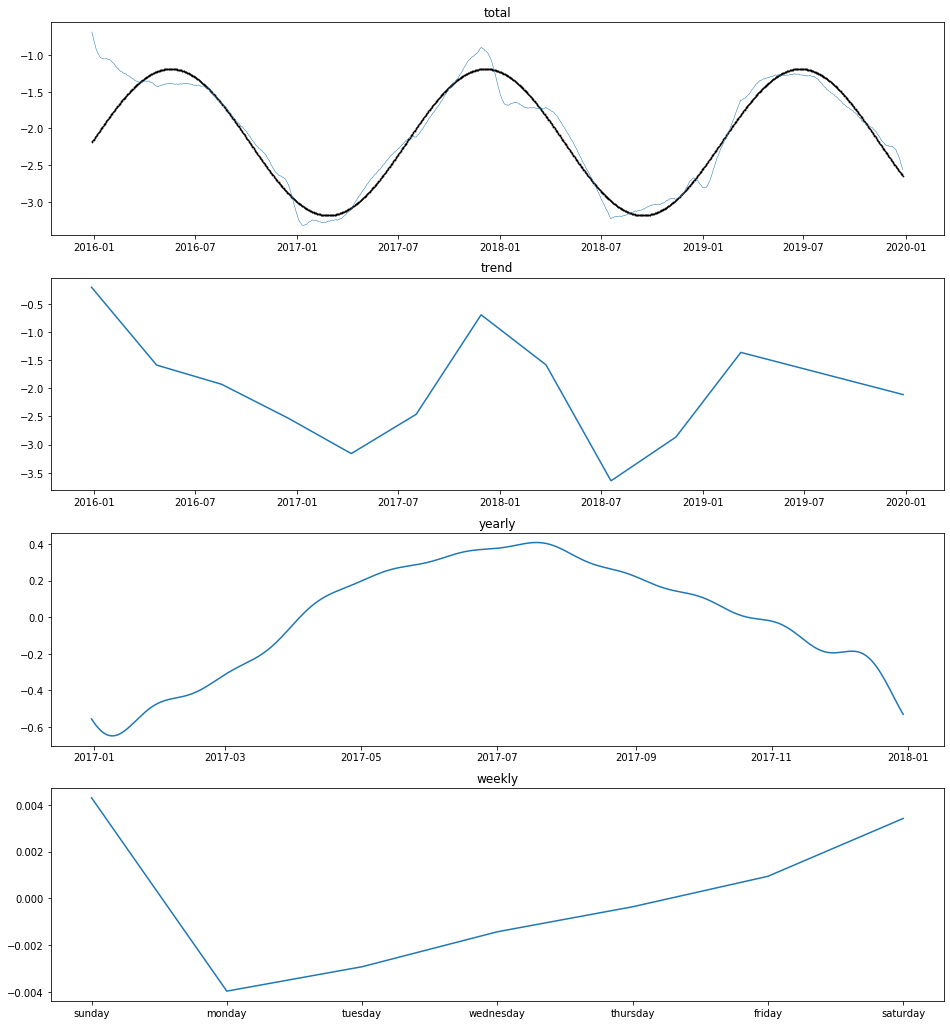

In [35]:
idx_series = 5

series_ds = ds[idx==idx_series]
series_beta_yearly = pe_beta_yearly[:,idx_series]
series_beta_weekly = pe_beta_weekly[:,idx_series]
series_t = t[idx==idx_series]
series_A = A[idx==idx_series, :]
series_F_yearly = F_yearly[idx==idx_series,:]
series_F_weekly = F_weekly[idx==idx_series,:]

# determine the posterior by evaulating all the values in the trace.
trend_posterior = (pe_k[idx_series] + np.dot(series_A, pe_delta[idx_series, :].T)) * series_t 
trend_posterior += pe_m[idx_series] + np.dot(series_A, (-s * pe_delta[idx_series, :]).T)

seasonality_yearly = det_seasonality_posterior(series_beta_yearly, series_F_yearly)
seasonality_weekly = det_seasonality_posterior(series_beta_weekly, series_F_weekly)

fitted = (trend_posterior + seasonality_yearly + seasonality_weekly) #.mean(1)

date = pd.Series(series_ds)
sunday = np.argmax(df['ds'].dt.dayofweek)
weekdays = ['sunday', 'monday', 'tuesday', 'wednesday', 'thursday', 'friday', 'saturday']
idx_year = np.argmax(df['ds'].dt.dayofyear)

plt.figure(figsize=(16, 3*6))
b = 411
plt.subplot(b)
plt.title('total')
plt.plot(date, fitted, lw=0.5)
plt.scatter(df['ds'], df['y_{}'.format(idx_series)], s=0.5, color='black')

plt.subplot(b + 1)
plt.title('trend')
plt.plot(date, trend_posterior[:])

plt.subplot(b + 2)
plt.title('yearly')
plt.plot(date[idx_year: idx_year + 365], seasonality_yearly[idx_year: idx_year + 365])

plt.subplot(b + 3)
plt.title('weekly')
plt.plot(weekdays, seasonality_weekly[sunday: sunday + 7])